<a href="https://colab.research.google.com/github/vicky1412/Predicting_stocks_usiang_deep_learning-models/blob/main/candle_color_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [ ]:
import datetime
import time
import math
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Import Data

In [ ]:
import yfinance as yf
data = yf.download("BTC-USD", period='60d',interval='5m')

#filter
data = data[['Open','Close']]

[*********************100%***********************]  1 of 1 completed


## Data Manipulating

In [ ]:
# Add Diff and Colors column

def colors(row):
  if row['Open'] < row['Close']:
    return 1
  elif row['Open'] > row['Close']:
    return 0
  else:
    return 0

# Get the color(candles)
data['Color'] = data.apply (lambda row: colors(row), axis=1)

# # Get color values and convert into numerical
# col = pd.DataFrame()
# col['Color'] = data.apply (lambda row: colors(row), axis=1)
# dummies = pd.get_dummies(col[['Color']])

# # Concatinate data with colors columns
# data = pd.concat([data, dummies], axis=1)
data = data.filter(['Color'])

In [ ]:
data

## Convert df--> np array

In [ ]:
#convert dataframe to a numpy array
dataset = data.values
#Get the no of rows to train the model on
training_data_len = math.ceil(len(dataset)*0.8)

## Scaling(0,1)

In [ ]:
#Scale the data(between 0 to 1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

## Create train dataset

In [ ]:
#create the train data set
train_data = scaled_data[0:training_data_len]
#split the data into x_train and y_train data set
x_train = []
y_train = []

#x_train = 60 values, y_train = 61st value
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i])
  y_train.append(train_data[i])

#convert x_train and y_train into numpy arrrays
x_train,y_train = np.array(x_train),np.array(y_train)

# #Reshape x_train to 3 dim because LSTM requires 3 dim
# x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [ ]:
x_train.dtype

dtype('float64')

## Building Model

In [ ]:
#Build the LSTM Model

model = Sequential()
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False, input_shape = (x_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
#compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

## Training the model

In [ ]:
#train the model
np.random.seed(42)
model.fit(x_train,y_train,batch_size=1,epochs=1)

## Create Test dataset

In [ ]:
#create the test data set
test_data = scaled_data[training_data_len-60:]
#split the data into x_train and y_train data set
x_test = []
y_test = dataset[training_data_len:]

#x_train = 60 values, y_train = 61st value
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i])

#convert x_train and y_train into numpy arrrays
x_test = np.array(x_test)

# #Reshape x_train to 3 dim because LSTM requires 3 dim
# x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

## Predict

In [ ]:
#Predict

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
predictions[0:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
predictions = np.round(predictions,decimals=1)
predictions = np.rint(predictions)
predictions = predictions.astype(int)

## Evaluate

In [ ]:
#Evaluate
np.random.seed(42)
mse = np.sqrt(np.mean(predictions - y_test)**2)
mse

0.08770900557348196

## Virtualize

In [ ]:
# Virtualize the train,test and valid

#Plot the data
train = data[0:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
valid['index']=np.arange(0,3409,1)
valid.set_index("index", inplace = True)

In [ ]:
valid.head()

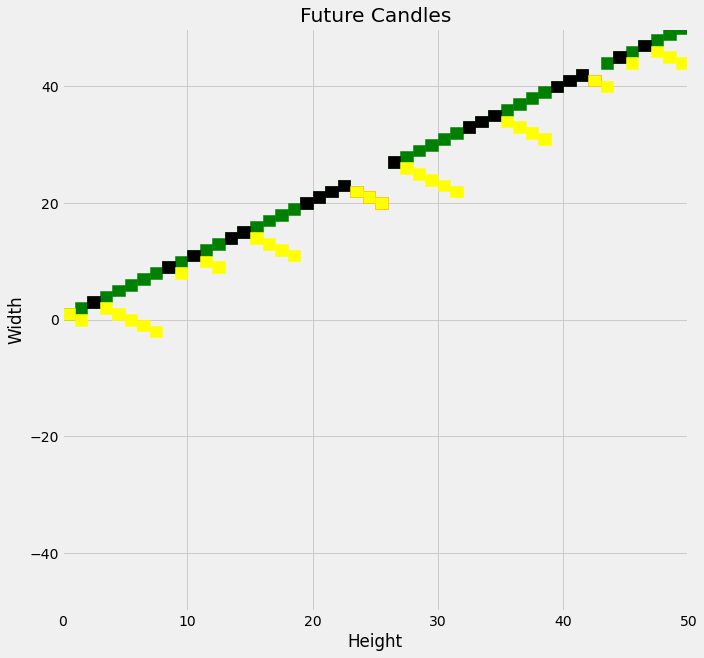

In [ ]:
# virtualize

fig, ax = plt.subplots(figsize=(10,10))

# Customize plot
ax.set(title="Future Candles", xlabel="Height", ylabel="Width")

plt.xlim([0, 50])
plt.ylim([-50, 50])

def rects(axx,ayy,cancolor):
  rect = matplotlib.patches.Rectangle((axx, ayy),
                                      1, 2,
                                      color =cancolor)
  return rect

for index, row in valid.iterrows():
  axx = index
  if row["Predictions"] == 1:
    ayy = index
    cancolor = 'green'
    rect = rects(axx,ayy,cancolor)
    ax.add_patch(rect)
  elif row["Predictions"] == 0:
    ayy = index if axx == 0 else (ayy-1)
    cancolor = 'red'
    rect = rects(axx,ayy,cancolor)
    ax.add_patch(rect)
  else:
    ayy = index-1
    cancolor = 'white'
    rect = rects(axx,ayy,cancolor)
    ax.add_patch(rect)

for index, row in valid.iterrows():
  axx = index
  if row["Color"] == 1:
    ayy = index
    cancolor = 'black'
    rect = rects(axx,ayy,cancolor)
    ax.add_patch(rect)
  elif row["Color"] == 0:
    ayy = index if axx == 0 else (ayy-1)
    cancolor = 'yellow'
    rect = rects(axx,ayy,cancolor)
    ax.add_patch(rect)
  else:
    ayy = index-1
    cancolor = 'white'
    rect = rects(axx,ayy,cancolor)
    ax.add_patch(rect)
  